In [2]:
import pandas as pd
from deltacd.utils.dss_to_df import dss_to_df
from deltacd.utils.deltacd2dsm2 import read_dcd
import xarray as xr
import matplotlib.pyplot as plt
import pyhecdss
import os
import numpy as np

%matplotlib inline

c:\Users\srajagop\.conda\envs\deltacd-2\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\Users\srajagop\.conda\envs\deltacd-2\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


# Read new DeltaCD output

In [3]:
ds = xr.open_dataset('../examples/Output/smcd_dsm2.nc')
dcd_dsm2_df = ds.to_dataframe()

# Convert netcdf to dataframe

In [4]:
new_drain_df = pd.pivot_table(dcd_dsm2_df, values = 'drainage', index = 'time', columns = 'node')
new_drain_df.index.name=None
new_drain_df.index.name = "datetime"

new_drain_df.columns.name = None

In [5]:
new_seep_df = pd.pivot_table(dcd_dsm2_df, values = 'seepage', index = 'time', columns = 'node')
new_seep_df.index.name=None
new_seep_df.index.name = "datetime"

new_seep_df.columns.name = None

In [6]:
new_div_df = pd.pivot_table(dcd_dsm2_df, values = 'diversion', index = 'time', columns = 'node')
new_div_df.index.name=None
new_div_df.index.name = "datetime"

new_div_df.columns.name = None
# new_div_df.columns = new_div_df.columns.droplevel()

In [ ]:
# print(new_div_df.columns)
# new_div_df.to_csv('new_div.csv',float_format ="%.2f")

In [ ]:
# new_div_df.groupby(pd.Grouper(freq='M'))['BBID'].sum().plot()

# convert old dss output to csv
## run once to convert dss to csv files

In [59]:

bparts_to_read=None
cpart_outnames = { 'DIV-FLOW':"div",'DRAIN-FLOW':"drain",'SEEP-FLOW':"seep"}
cparts_to_read=cpart_outnames.keys()
eparts_to_read=None
fparts_to_read=None
start_date_str=None
end_date_str=None
fpath = r'D:\Documents\projects\CADWRDeltaModeling\deltaCD-master\deltacd\tests\dcdv1.3_dss_outputs\smcd_dsm2\SMCD_pond_Sep2024_1.dss'
# outfile_prefix = os.path.splitext(os.path.basename(fpath))[0]
outfile_prefix = 'dcdv1.3_smcd_dsm2'
dssfile = pyhecdss.DSSFile(fpath)
cat = dssfile.read_catalog()
paths = dssfile.get_pathnames()
# dfs = []
for cpart in cparts_to_read:
        dfs=pd.DataFrame()
        outfile=outfile_prefix+'_'+cpart_outnames[cpart]+'.csv'
        plist=dssfile.get_pathnames(cat[cat.C==cpart])
        for path in plist:
            parts = path.split('/')
            node = parts[2]
            # print(node)
            # if bparts_to_read is not None and parts[2] not in bparts_to_read:
            #     continue
            # if cparts_to_read is not None and parts[3] not in cparts_to_read:
            #     continue
            # if eparts_to_read is not None and parts[5] not in eparts_to_read:
            #     continue
            # if fparts_to_read is not None and parts[6] not in fparts_to_read:
            #     continue
            data, cunits, ctype = dssfile.read_rts(path, start_date_str,
                                                    end_date_str)
            # try:
            #         data.index = data.index.to_timestamp()
            # except:
            #         pass
            # data = pd.melt(data.reset_index(), id_vars=[
            #                 'index'], value_vars=[path], var_name='pathname')
            # data.rename(columns={'index': 'time'}, inplace=True)
            try:
                dfs[node] = data
            except (AttributeError,TypeError):
                dfs=data
                dfs.columns=[node]
            dfs.index.name = "datetime"
        dfs.to_csv(outfile,float_format="%.2f",date_format="%Y-%m-%dT%H:%M")

In [7]:
dsm2_old_div_df = pd.read_csv("dcdv1.3_smcd_dsm2_div.csv",parse_dates=[0],index_col=0)
dsm2_old_div_df.columns = dsm2_old_div_df.columns.astype(int)

div_diff_df = new_div_df.subtract(dsm2_old_div_df)

div_pc_df = new_div_df.subtract(dsm2_old_div_df).div(dsm2_old_div_df).multiply(100)



In [ ]:
# print(div_diff_df)

In [8]:
diff_desc = div_diff_df.replace([np.inf, -np.inf],np.nan).describe()
diff_desc = diff_desc.T
# diff_desc.to_csv("div_diff_desc.csv")

pc_desc = div_pc_df.replace([np.inf, -np.inf],np.nan).describe()
pc_desc = pc_desc.T
# pc_desc.to_csv("div_pc_desc.csv")

In [ ]:
# print(diff_desc.index)

Text(0.5, 0, 'node')

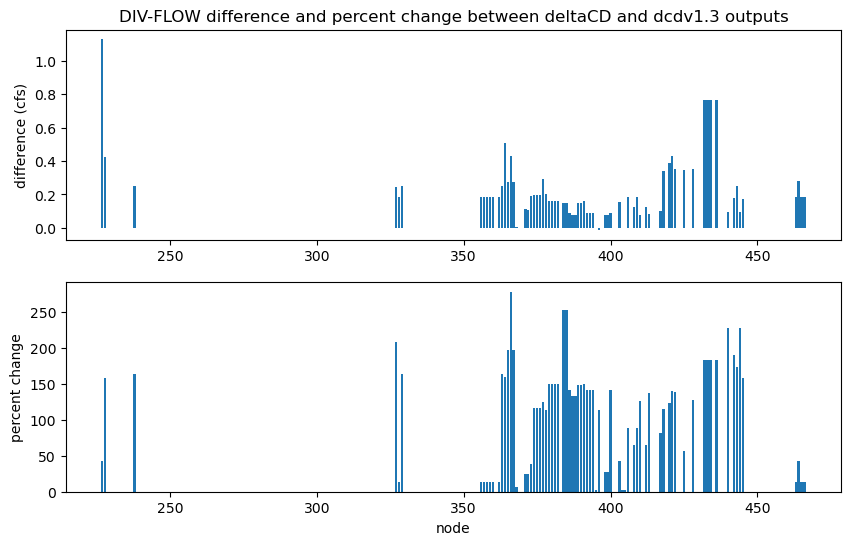

In [9]:
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1)
plt.title('DIV-FLOW difference and percent change between deltaCD and dcdv1.3 outputs')
plt.bar(diff_desc.index,diff_desc['mean'])
plt.ylabel('difference (cfs)')
# plt.xticks(np.arange(1, 257+1, 17))

plt.subplot(2, 1, 2)
plt.bar(pc_desc.index.values,pc_desc['mean'])
plt.ylabel('percent change')
plt.xlabel('node')
# plt.xticks(np.arange(1, 257+1, 17))
# plt.savefig('smcd_dsm2_div_diff_pc.png')

In [10]:
dsm2_old_drain_df = pd.read_csv("dcdv1.3_smcd_dsm2_drain.csv",parse_dates=[0],index_col=0)
dsm2_old_drain_df.columns = dsm2_old_drain_df.columns.astype(int)
drain_diff_df = new_drain_df - dsm2_old_drain_df
drain_pc_df = new_drain_df.subtract(dsm2_old_drain_df).div(dsm2_old_drain_df).multiply(100)


In [11]:
diff_desc = drain_diff_df.replace([np.inf, -np.inf],np.nan).describe()
diff_desc = diff_desc.T
# diff_desc.to_csv("drain_diff_desc.csv")

pc_desc = drain_pc_df.replace([np.inf, -np.inf],np.nan).describe()
pc_desc = pc_desc.T
# pc_desc.to_csv("drain_pc_desc.csv")

Text(0.5, 0, 'node')

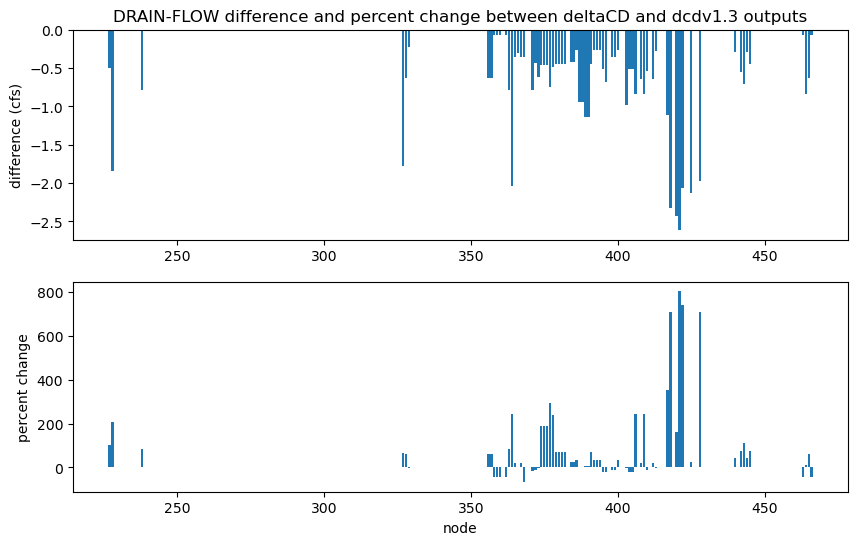

In [12]:
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1)
plt.title('DRAIN-FLOW difference and percent change between deltaCD and dcdv1.3 outputs')
plt.bar(diff_desc.index,diff_desc['mean'])
plt.ylabel('difference (cfs)')
# plt.xticks(np.arange(1, 257+1, 17))

plt.subplot(2, 1, 2)
plt.bar(pc_desc.index,pc_desc['mean'])
plt.ylabel('percent change')
plt.xlabel('node')
# plt.xticks(np.arange(1, 257+1, 17))
# plt.savefig('smcd_dsm2_drain_diff_pc.png')

In [13]:
dsm2_old_seep_df = pd.read_csv("dcdv1.3_smcd_dsm2_seep.csv",parse_dates=[0],index_col=0)
dsm2_old_seep_df.columns = dsm2_old_seep_df.columns.astype(int)
seep_diff_df = new_seep_df - dsm2_old_seep_df
seep_pc_df = new_seep_df.subtract(dsm2_old_seep_df).div(dsm2_old_seep_df).multiply(100)


In [14]:
diff_desc = seep_diff_df.replace([np.inf, -np.inf],np.nan).describe()
diff_desc = diff_desc.T
# diff_desc.to_csv("seep_diff_desc.csv")

pc_desc = seep_pc_df.replace([np.inf, -np.inf],np.nan).describe()
pc_desc = pc_desc.T
# pc_desc.to_csv("seep_pc_desc.csv")

Text(0.5, 0, 'node')

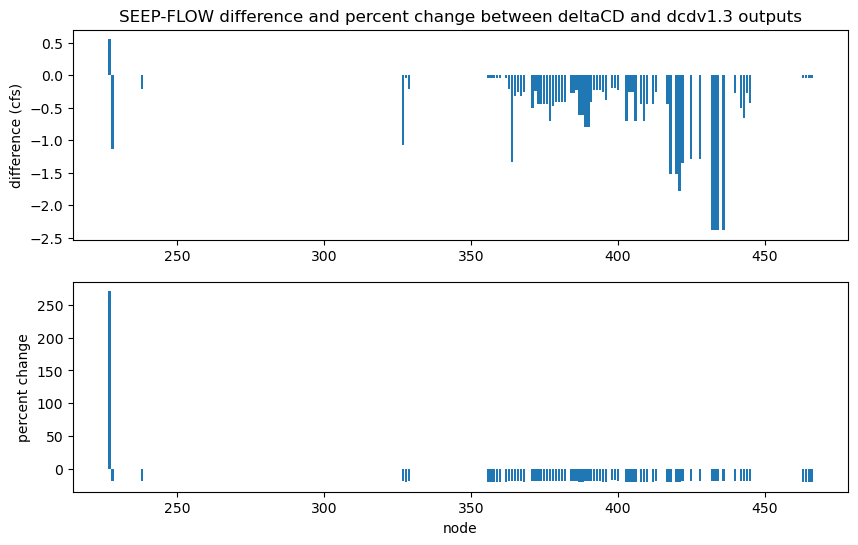

In [15]:
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1)
plt.title('SEEP-FLOW difference and percent change between deltaCD and dcdv1.3 outputs')
plt.bar(diff_desc.index,diff_desc['mean'])
plt.ylabel('difference (cfs)')
# plt.xticks(np.arange(1, 257+1, 17))

plt.subplot(2, 1, 2)
plt.bar(pc_desc.index,pc_desc['mean'])
plt.ylabel('percent change')
plt.xlabel('node')
# plt.xticks(np.arange(1, 257+1, 17))
# plt.savefig('smcd_dsm2_seep_diff_pc.png')